In [2]:
import numpy as np
from vpsto import VPSTO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon, Point, MultiPoint, LineString

In [3]:
# Define some polygons for creating a collision environment
class CollisionEnvironment():
    def __init__(self):
        self.poly_list = []
        self.poly_list.append(np.array([[0.1, 0.13], [0.23, 0.12], [0.19, 0.28], [0.1, 0.32], [0.16, 0.2]]))
        self.poly_list.append(np.array([[0.25, 0.34], [0.31, 0.35], [0.32, 0.41], [0.27, 0.44], [0.23, 0.4]]))
        self.poly_list.append(np.array([[0.35, 0.12], [0.38, 0.1], [0.41, 0.11], [0.42, 0.21], [0.35, 0.24]]))
        self.multi_poly = MultiPolygon([Polygon(self.poly_list[0]), Polygon(self.poly_list[1]), Polygon(self.poly_list[2])])
        
    def getTrajDist(self, pts):
        return self.multi_poly.intersection(LineString(pts)).length

In [40]:
q_min = 0.0*np.ones(2)
q_max = 0.5*np.ones(2)
def loss_limits(candidates):
    q = candidates['pos']
    d_min = np.maximum(np.zeros_like(q), - q + q_min)
    d_max = np.maximum(np.zeros_like(q), q - q_max)
    return np.sum(d_min > 0.0, axis=(1,2)) + np.sum(d_max > 0.0, axis=(1,2))

env = CollisionEnvironment()
def loss_collision(candidates): 
    costs = []
    for traj in candidates['pos']:
        costs.append(env.getTrajDist(traj))
    costs = np.array(costs)
    costs += costs > 0.0
    return costs

def loss_curvature(candidates):
    dq = candidates['vel']
    ddq = candidates['acc']
    dq_sq = np.sum(dq**2, axis=-1)
    ddq_sq = np.sum(ddq**2, axis=-1)
    dq_ddq = np.sum(dq*ddq, axis=-1) 
    return np.mean((dq_sq * ddq_sq - dq_ddq**2) / (dq_sq**3 + 1e-6), axis=-1)

def loss(candidates):
    cost_curvature = loss_curvature(candidates)
    cost_collision = loss_collision(candidates)
    cost_limits = loss_limits(candidates)
    return candidates['T'] + 1e-3 * cost_curvature + 1e3 * cost_collision + 1e-3 * cost_limits

In [41]:
traj_opt = VPSTO(ndof=2)

traj_opt.opt.N_via = 20
traj_opt.opt.vel_lim = np.array([0.5, 0.5])
traj_opt.opt.acc_lim = np.array([0.05, 0.05])
traj_opt.opt.max_iter = 500

In [42]:
q0 = np.array([0.5, 5.0]) # robot position
qd = np.array([2.5, 8.0])  # desired robot position

In [43]:
sol = traj_opt.minimize(loss, q_0=q0, q_T=qd)

t_traj = np.linspace(0, sol.T_best, 1000)
pos, vel, acc = sol.get_trajectory(t_traj)

print('Movement duration: ', sol.T_best)

VP-STO finished after 500 iterations with a final loss of 115067.03653510561st:  115075.33521058266 249 cost:  115068.44484027181 268 cost:  115068.60801780497 330 cost:  115067.49329556496 353 cost:  115067.42353658294 392 cost:  115067.2265856032 115067.15228727234
Movement duration:  67.06589990511493


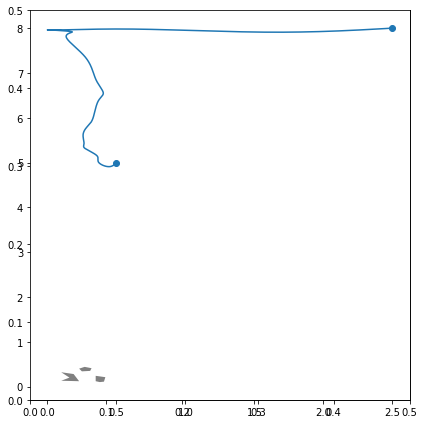

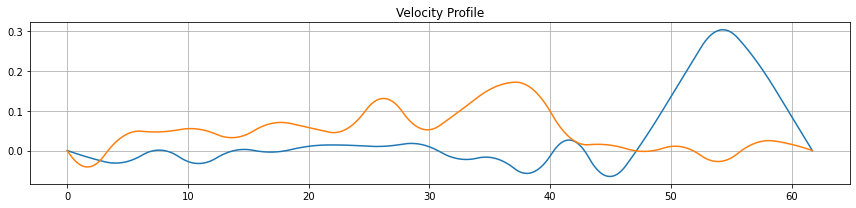

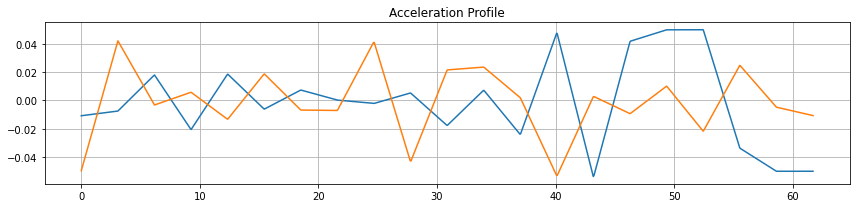

In [39]:
plt.figure(figsize=(6,6))

plt.xlim([q_min[0], q_max[0]])
plt.ylim([q_min[1], q_max[1]])
ax = plt.axes()

plt.scatter([q0[0], qd[0]],[q0[1], qd[1]])
for pol in env.poly_list:
    ax.add_patch(patches.Polygon(pol, facecolor = 'gray'))

plt.plot(pos[:,0], pos[:,1])
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Velocity Profile')
plt.plot(t_traj, vel)
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Acceleration Profile')
plt.plot(t_traj, acc)
plt.tight_layout()